In [1]:
import io
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

In [2]:
# TODO add more data where pulse compression is performed?
# TODO add cross poll if sentinel-xarray has noise floor
# TODO use training data from half the image and apply on the other
# TODO use normalized backscatter ?
# TODO ship/bright signal removal?

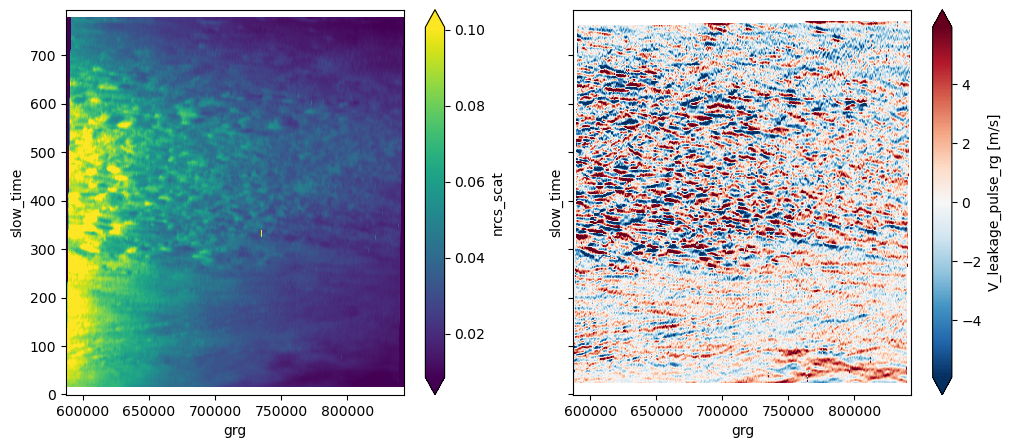

In [3]:
data = xr.open_dataset('scatt4ML2.nc')
# data = data.dropna(dim= 'slow_time', how = 'all').dropna(dim='grg', how='any')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
data.nrcs_scat.T.plot(robust=True, ax = axes[0])
data.V_leakage_pulse_rg.T.plot(robust=True, ax = axes[1])

In [4]:
n = 20
spacing_slow_time = n # pixels
spacing_ground_range = 10 # pixels
test_range_slow_time = (200, 400) # pixels

X_data = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder')
y_data = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder')

## - Train / Test data

In order to improve training data is sampled with spacing in range and slow time. This avoids including neighbouring or successive samples which are statistically similar to each other, leading towards too heaviliy idealized training conditions and overfitting. By spacing each sample they are (more) independent providing more reliable data.

In [5]:
# Training

X_train = X_data.isel(placeholder=slice(None, test_range_slow_time[0] -1))               # before slice
X_train = xr.concat([X_train, X_data.isel(placeholder=slice(test_range_slow_time[1] + 1, None))], dim='placeholder') # after slice
X_train_spaced = X_train.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1, 2*n+1)

y_train = y_data.isel(placeholder=slice(None, test_range_slow_time[0] -1))               # before slice
y_train = xr.concat([y_train, y_data.isel(placeholder=slice(test_range_slow_time[1] + 1, None))], dim='placeholder') 
y_train_spaced = y_train.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1)

data_train = pd.DataFrame(np.column_stack((X_train_spaced,y_train_spaced))).dropna()
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]

In [6]:
# Testing

X_test = X_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1, 2*n+1)
y_test = y_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1)

data_test = pd.DataFrame(np.column_stack((X_test,y_test))).dropna()
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape )

(148180, 41) (1933, 41) (148180,) (1933,)


## - Regression

In [9]:
# Instantiate model and overwrite automated Train / Test split

ML = AutomatedRegression(
    X=X_test,           # NOTE these are overwritten 
    y=X_test,           # NOTE these are overwritten 
    n_trial=50,
    models_to_optimize=['bayesianridge', 'lightgbm'],
    reload_study=True,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_30_V_split_scene_spaced_traintest/',
)

ML.X_test = X_test
ML.X_train = X_train
ML.y_test = y_test 
ML.y_train = y_train 

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))


In [10]:
# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML.apply()
    
sys.stdout = sys.__stdout__

[I 2023-11-24 16:46:52,162] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-11-24 16:46:52,241] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-11-24 16:46:52,284] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-11-24 16:46:52,327] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


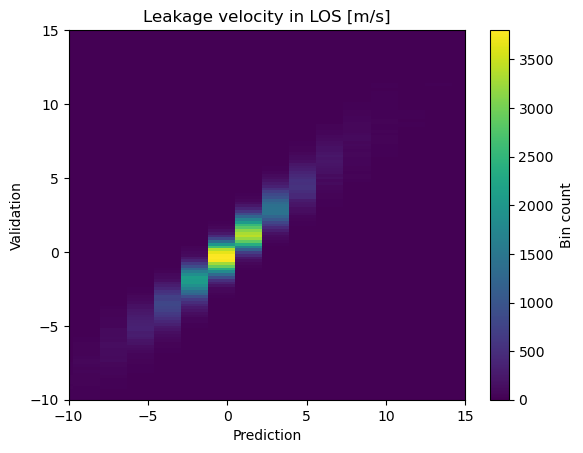

{'bayesianridge_best': [[0.5294212972783647, 0.0054994355586541095],
  [0.19108979102991341, 0.4626113499563886]],
 'lightgbm_best': [[0.5673265298356023, 0.0034305620876257346],
  [0.8686781930683386, 0.003197984290496914]],
 'stacked': [[0.4315080416616762, 0.0012399723930935848],
  [0.7848270541263116, 0.09586101117363757]]}

In [11]:
plt.hist2d(ML.y_pred, np.ravel(ML.y_test.values), bins=(200,200)) #, gridsize=10, cmap='Blues', edgecolors='gray', mincnt=1)
plt.xlim([-10, 15]); plt.ylim([-10, 15])
plt.colorbar(label='Bin count')
plt.title('Leakage velocity in LOS [m/s]')
plt.xlabel('Prediction')
plt.ylabel('Validation')
plt.show()

ML.summary

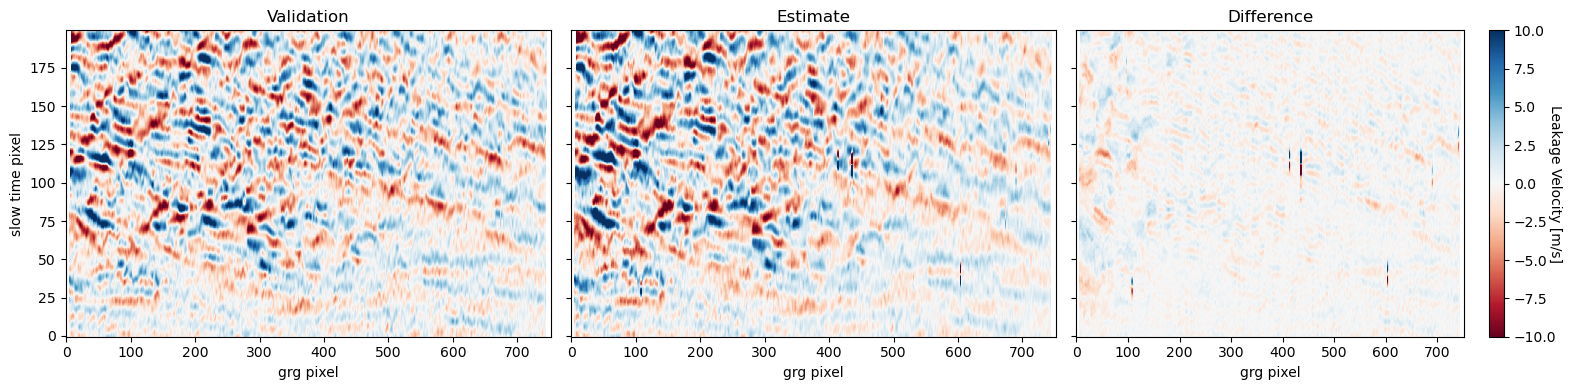

In [20]:
theoretical_length = y_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1).shape
A = np.nan * np.arange(theoretical_length[0])
A[y_test.index.values] = ML.y_test.values
A = A.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1))

B = np.nan * np.arange(theoretical_length[0])
B[y_test.index.values] = ML.y_pred
B = B.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1))

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

vmin = -10;
vmax = 10
im0 = axes[0].imshow(A, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
im1 = axes[1].imshow(B.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1)), origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
im2 = axes[2].imshow(A - B, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
[ax.set_xlabel('grg pixel') for ax in axes]
axes[0].set_ylabel('slow time pixel')
axes[0].set_title('Validation')
axes[1].set_title('Estimate')
axes[2].set_title('Difference')
cbar = plt.colorbar(im0, ax=axes[2])
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
fig.tight_layout()

## More complex model

In [7]:
# Instantiate model and overwrite automated Train / Test split

ML2 = AutomatedRegression(
    X=X_test,           # NOTE these are overwritten 
    y=X_test,           # NOTE these are overwritten 
    n_trial=100,
    models_to_optimize=['bayesianridge', 'lightgbm', 'catboost', 'xgboost'],
    n_jobs=6,
    n_weak_models=5,
    reload_study=True,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_20_V_split_scene_spaced_traintest_complex/',
)

ML2.X_test = X_test
ML2.X_train = X_train
ML2.y_test = y_test 
ML2.y_train = y_train 

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))


In [8]:
# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML2.apply()
    
sys.stdout = sys.__stdout__

[I 2023-11-25 12:21:46,138] A new study created in RDB with name: regression_bayesianridge
[I 2023-11-25 12:21:47,237] Trial 0 finished with value: 0.42175327470075336 and parameters: {'scaler': None, 'n_iter': 146, 'tol': 7.401105581387332, 'alpha_1': 0.028604244623283013, 'alpha_2': 1.670655885588709e-05, 'lambda_1': 2.668366347304525e-07, 'lambda_2': 2.225026701462595e-06, 'transformers': 'quantile_trans', 'n_quantiles': 1600}. Best is trial 0 with value: 0.42175327470075336.
[I 2023-11-25 12:21:48,683] Trial 4 finished with value: -0.00518879941776249 and parameters: {'scaler': None, 'n_iter': 305, 'tol': 77.19117558409141, 'alpha_1': 3.6853829475146523e-07, 'alpha_2': 0.011485657885354956, 'lambda_1': 96.00142583424999, 'lambda_2': 9.637470326108782e-05, 'transformers': None}. Best is trial 0 with value: 0.42175327470075336.
[I 2023-11-25 12:21:48,807] Trial 5 finished with value: 0.8329585096498775 and parameters: {'scaler': None, 'n_iter': 257, 'tol': 52.7477518290834, 'alpha_1'

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=14.64347599845006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.64347599845006
[LightGBM] [Warning] feature_fraction is set=0.14183153475159638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14183153475159638
[LightGBM] [Warning] bagging_fraction is set=0.9919244881440171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9919244881440171
[LightGBM] [Warning] lambda_l2 is set=0.008828438872964972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008828438872964972
[LightGBM] [Warning] lambda_l1 is set=1.313310996821082e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.313310996821082e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=2.1395

[I 2023-11-25 12:22:33,355] Trial 2 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=14.64347599845006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.64347599845006
[LightGBM] [Warning] feature_fraction is set=0.14183153475159638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14183153475159638
[LightGBM] [Warning] bagging_fraction is set=0.9919244881440171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9919244881440171
[LightGBM] [Warning] lambda_l2 is set=0.008828438872964972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008828438872964972
[LightGBM] [Warning] lambda_l1 is set=1.313310996821082e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.313310996821082e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=11.728

[I 2023-11-25 12:22:33,706] Trial 4 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.533274389849963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.533274389849963
[LightGBM] [Warning] feature_fraction is set=0.5358810009814955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5358810009814955
[LightGBM] [Warning] bagging_fraction is set=0.8241449314212764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241449314212764
[LightGBM] [Warning] lambda_l2 is set=4.735411363124347e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.735411363124347e-06
[LightGBM] [Warning] lambda_l1 is set=8.82444451490235e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.82444451490235e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.321493

[I 2023-11-25 12:22:36,755] Trial 0 finished with value: 0.036434063662266244 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 4, 'n_estimators': 1052, 'max_bin': 127, 'min_gain_to_split': 1.2467033279736488, 'lambda_l1': 2.3764610641735556e-06, 'lambda_l2': 0.0119141029560265, 'num_leaves': 244, 'feature_fraction': 0.7762928026787546, 'bagging_fraction': 0.9128650174899098, 'bagging_freq': 3, 'min_child_samples': 22, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 100}. Best is trial 0 with value: 0.036434063662266244.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=11.728926428396514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.728926428396514
[LightGBM] [Warning] feature_fraction is set=0.885488536057366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.885488536057366
[LightGBM] [Warning] bagging_fraction is set=0.5190716859958187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5190716859958187
[LightGBM] [Warning] lambda_l2 is set=1.269522655594344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.269522655594344
[LightGBM] [Warning] lambda_l1 is set=0.00623120904822237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00623120904822237
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=13.151257239288555

[I 2023-11-25 12:22:41,422] Trial 1 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=1.3038596615994007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3038596615994007
[LightGBM] [Warning] feature_fraction is set=0.9133609156901095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9133609156901095
[LightGBM] [Warning] bagging_fraction is set=0.6897756268231695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897756268231695
[LightGBM] [Warning] lambda_l2 is set=0.0009022243773144436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009022243773144436
[LightGBM] [Warning] lambda_l1 is set=1.4110259016738157e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4110259016738157e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=14

[I 2023-11-25 12:22:45,000] Trial 3 finished with value: 0.5375256667025834 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 252, 'max_bin': 1023, 'min_gain_to_split': 14.64347599845006, 'lambda_l1': 1.313310996821082e-06, 'lambda_l2': 0.008828438872964972, 'num_leaves': 255, 'feature_fraction': 0.14183153475159638, 'bagging_fraction': 0.9919244881440171, 'bagging_freq': 4, 'min_child_samples': 10, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 3 with value: 0.5375256667025834.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=1.3038596615994007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3038596615994007
[LightGBM] [Warning] feature_fraction is set=0.9133609156901095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9133609156901095
[LightGBM] [Warning] bagging_fraction is set=0.6897756268231695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897756268231695
[LightGBM] [Warning] lambda_l2 is set=0.0009022243773144436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009022243773144436
[LightGBM] [Warning] lambda_l1 is set=1.4110259016738157e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4110259016738157e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=11

[I 2023-11-25 12:22:50,362] Trial 6 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=1.3038596615994007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3038596615994007
[LightGBM] [Warning] feature_fraction is set=0.9133609156901095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9133609156901095
[LightGBM] [Warning] bagging_fraction is set=0.6897756268231695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897756268231695
[LightGBM] [Warning] lambda_l2 is set=0.0009022243773144436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009022243773144436
[LightGBM] [Warning] lambda_l1 is set=1.4110259016738157e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4110259016738157e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=12

[I 2023-11-25 12:22:56,015] Trial 5 pruned. 
[I 2023-11-25 12:22:56,116] Trial 10 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3879725237565632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3879725237565632
[LightGBM] [Warning] feature_fraction is set=0.9168077761635784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168077761635784
[LightGBM] [Warning] bagging_fraction is set=0.8169451840537203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8169451840537203
[LightGBM] [Warning] lambda_l2 is set=2.3651913368111233e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3651913368111233e-07
[LightGBM] [Warning] lambda_l1 is set=2.1188401208334573e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1188401208334573e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:23:03,599] Trial 11 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.533274389849963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.533274389849963
[LightGBM] [Warning] feature_fraction is set=0.5358810009814955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5358810009814955
[LightGBM] [Warning] bagging_fraction is set=0.8241449314212764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241449314212764
[LightGBM] [Warning] lambda_l2 is set=4.735411363124347e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.735411363124347e-06
[LightGBM] [Warning] lambda_l1 is set=8.82444451490235e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.82444451490235e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.687931

[I 2023-11-25 12:23:07,141] Trial 13 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.533274389849963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.533274389849963
[LightGBM] [Warning] feature_fraction is set=0.5358810009814955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5358810009814955
[LightGBM] [Warning] bagging_fraction is set=0.8241449314212764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241449314212764
[LightGBM] [Warning] lambda_l2 is set=4.735411363124347e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.735411363124347e-06
[LightGBM] [Warning] lambda_l1 is set=8.82444451490235e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.82444451490235e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=10.93334

[I 2023-11-25 12:23:10,674] Trial 7 finished with value: 0.5814422005739459 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 15, 'n_estimators': 698, 'max_bin': 511, 'min_gain_to_split': 9.533274389849963, 'lambda_l1': 8.82444451490235e-08, 'lambda_l2': 4.735411363124347e-06, 'num_leaves': 22, 'feature_fraction': 0.5358810009814955, 'bagging_fraction': 0.8241449314212764, 'bagging_freq': 3, 'min_child_samples': 93, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 7 with value: 0.5814422005739459.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=8.526873865511472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.526873865511472
[LightGBM] [Warning] feature_fraction is set=0.34065274216807434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34065274216807434
[LightGBM] [Warning] bagging_fraction is set=0.45295765838594343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45295765838594343
[LightGBM] [Warning] lambda_l2 is set=1.39613549482717e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.39613549482717e-06
[LightGBM] [Warning] lambda_l1 is set=0.9045027425778885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9045027425778885
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.37961209

[I 2023-11-25 12:23:12,001] Trial 14 pruned. 
[I 2023-11-25 12:23:12,016] Trial 15 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3879725237565632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3879725237565632
[LightGBM] [Warning] feature_fraction is set=0.9168077761635784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168077761635784
[LightGBM] [Warning] bagging_fraction is set=0.8169451840537203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8169451840537203
[LightGBM] [Warning] lambda_l2 is set=2.3651913368111233e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3651913368111233e-07
[LightGBM] [Warning] lambda_l1 is set=2.1188401208334573e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1188401208334573e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:23:13,674] Trial 8 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.379612097567966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.379612097567966
[LightGBM] [Warning] feature_fraction is set=0.1996715365691619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1996715365691619
[LightGBM] [Warning] bagging_fraction is set=0.7331300517423573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331300517423573
[LightGBM] [Warning] lambda_l2 is set=3.5750648301744845e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5750648301744845e-06
[LightGBM] [Warning] lambda_l1 is set=0.010278072824727109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010278072824727109
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=10.673

[I 2023-11-25 12:23:14,333] Trial 9 finished with value: 0.7102387927491891 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 11, 'n_estimators': 286, 'max_bin': 255, 'min_gain_to_split': 1.3038596615994007, 'lambda_l1': 1.4110259016738157e-06, 'lambda_l2': 0.0009022243773144436, 'num_leaves': 20, 'feature_fraction': 0.9133609156901095, 'bagging_fraction': 0.6897756268231695, 'bagging_freq': 6, 'min_child_samples': 97, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 9 with value: 0.7102387927491891.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=9.656930826125803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.656930826125803
[LightGBM] [Warning] feature_fraction is set=0.8168411075319694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8168411075319694
[LightGBM] [Warning] bagging_fraction is set=0.21665774370695168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21665774370695168
[LightGBM] [Warning] lambda_l2 is set=0.03149422876684432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03149422876684432
[LightGBM] [Warning] lambda_l1 is set=0.03529069992191412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03529069992191412
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.3796120975

[I 2023-11-25 12:23:17,488] Trial 20 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=11.348698200723597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.348698200723597
[LightGBM] [Warning] feature_fraction is set=0.5202150453319209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5202150453319209
[LightGBM] [Warning] bagging_fraction is set=0.18705599648144094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18705599648144094
[LightGBM] [Warning] lambda_l2 is set=0.03684386350312014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03684386350312014
[LightGBM] [Warning] lambda_l1 is set=0.01265349206380764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01265349206380764
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.37961209

[I 2023-11-25 12:23:28,046] Trial 19 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.379612097567966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.379612097567966
[LightGBM] [Warning] feature_fraction is set=0.1996715365691619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1996715365691619
[LightGBM] [Warning] bagging_fraction is set=0.7331300517423573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331300517423573
[LightGBM] [Warning] lambda_l2 is set=3.5750648301744845e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5750648301744845e-06
[LightGBM] [Warning] lambda_l1 is set=0.010278072824727109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010278072824727109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=5.7397

[I 2023-11-25 12:23:31,364] Trial 22 pruned. 


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=11.348698200723597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.348698200723597
[LightGBM] [Warning] feature_fraction is set=0.5202150453319209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5202150453319209
[LightGBM] [Warning] bagging_fraction is set=0.18705599648144094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18705599648144094
[LightGBM] [Warning] lambda_l2 is set=0.03684386350312014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03684386350312014
[LightGBM] [Warning] lambda_l1 is set=0.01265349206380764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01265349206380764
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=8.37961209

[I 2023-11-25 12:23:39,767] Trial 21 finished with value: 0.7123446433914647 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 191, 'max_bin': 1023, 'min_gain_to_split': 5.6154720743056314, 'lambda_l1': 7.824484339388546e-07, 'lambda_l2': 0.11316566381493402, 'num_leaves': 166, 'feature_fraction': 0.9789094820283188, 'bagging_fraction': 0.689606865414441, 'bagging_freq': 5, 'min_child_samples': 3, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.429257473106423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.429257473106423
[LightGBM] [Warning] feature_fraction is set=0.9830540518268438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830540518268438
[LightGBM] [Warning] bagging_fraction is set=0.6431959847378902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6431959847378902
[LightGBM] [Warning] lambda_l2 is set=0.2063394720988377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2063394720988377
[LightGBM] [Warning] lambda_l1 is set=2.150407285226709e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150407285226709e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=5.5956421740

[I 2023-11-25 12:23:41,577] Trial 16 finished with value: 0.5537968758970546 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 17, 'n_estimators': 483, 'max_bin': 1023, 'min_gain_to_split': 8.379612097567966, 'lambda_l1': 0.010278072824727109, 'lambda_l2': 3.5750648301744845e-06, 'num_leaves': 80, 'feature_fraction': 0.1996715365691619, 'bagging_fraction': 0.7331300517423573, 'bagging_freq': 5, 'min_child_samples': 83, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=10.70461874977175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.70461874977175
[LightGBM] [Warning] feature_fraction is set=0.6051083908373583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6051083908373583
[LightGBM] [Warning] bagging_fraction is set=0.4716544917316068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4716544917316068
[LightGBM] [Warning] lambda_l2 is set=0.012725387321338363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012725387321338363
[LightGBM] [Warning] lambda_l1 is set=2.1032876357716512e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1032876357716512e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3879

[I 2023-11-25 12:23:51,427] Trial 17 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.429257473106423, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.429257473106423
[LightGBM] [Warning] feature_fraction is set=0.9830540518268438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830540518268438
[LightGBM] [Warning] bagging_fraction is set=0.6431959847378902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6431959847378902
[LightGBM] [Warning] lambda_l2 is set=0.2063394720988377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2063394720988377
[LightGBM] [Warning] lambda_l1 is set=2.150407285226709e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150407285226709e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.7677312250

[I 2023-11-25 12:23:54,204] Trial 23 finished with value: 0.7065375906202098 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 174, 'max_bin': 1023, 'min_gain_to_split': 5.595642174050099, 'lambda_l1': 4.0797191540504875e-07, 'lambda_l2': 0.026415756718241888, 'num_leaves': 165, 'feature_fraction': 0.9570879523439757, 'bagging_fraction': 0.6916107972192043, 'bagging_freq': 5, 'min_child_samples': 1, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.34018957856625587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34018957856625587
[LightGBM] [Warning] feature_fraction is set=0.9725462161348288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9725462161348288
[LightGBM] [Warning] bagging_fraction is set=0.6465882383390607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6465882383390607
[LightGBM] [Warning] lambda_l2 is set=0.2694045453220225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2694045453220225
[LightGBM] [Warning] lambda_l1 is set=1.5852504909548265e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5852504909548265e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=5.4292

[I 2023-11-25 12:23:56,900] Trial 27 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.767731225031298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.767731225031298
[LightGBM] [Warning] feature_fraction is set=0.38547165187210086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38547165187210086
[LightGBM] [Warning] bagging_fraction is set=0.427201719006945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.427201719006945
[LightGBM] [Warning] lambda_l2 is set=0.05468709565833893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05468709565833893
[LightGBM] [Warning] lambda_l1 is set=8.024178332238249e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.024178332238249e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=3.39225573

[I 2023-11-25 12:23:57,654] Trial 18 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=3.392255737582761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.392255737582761
[LightGBM] [Warning] feature_fraction is set=0.667894581515984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.667894581515984
[LightGBM] [Warning] bagging_fraction is set=0.6141022325937621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6141022325937621
[LightGBM] [Warning] lambda_l2 is set=0.0007573160912174359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007573160912174359
[LightGBM] [Warning] lambda_l1 is set=0.0005404722637599838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005404722637599838
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.861015

[I 2023-11-25 12:23:58,647] Trial 28 pruned. 


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.861015036527691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.861015036527691
[LightGBM] [Warning] feature_fraction is set=0.8566626246572742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8566626246572742
[LightGBM] [Warning] bagging_fraction is set=0.13029341764330565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13029341764330565
[LightGBM] [Warning] lambda_l2 is set=3.28877041966468e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.28877041966468e-05
[LightGBM] [Warning] lambda_l1 is set=0.00155091644381619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00155091644381619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.22241128

[I 2023-11-25 12:23:59,375] Trial 25 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.029135992617224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.029135992617224
[LightGBM] [Warning] feature_fraction is set=0.7809385813213937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809385813213937
[LightGBM] [Warning] bagging_fraction is set=0.6937013263505398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6937013263505398
[LightGBM] [Warning] lambda_l2 is set=4.589075815737479e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.589075815737479e-07
[LightGBM] [Warning] lambda_l1 is set=7.032946234269496e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032946234269496e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.8610

[I 2023-11-25 12:24:00,030] Trial 24 finished with value: 0.6992651519005781 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 8, 'n_estimators': 145, 'max_bin': 255, 'min_gain_to_split': 5.429257473106423, 'lambda_l1': 2.150407285226709e-07, 'lambda_l2': 0.2063394720988377, 'num_leaves': 152, 'feature_fraction': 0.9830540518268438, 'bagging_fraction': 0.6431959847378902, 'bagging_freq': 7, 'min_child_samples': 1, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.861015036527691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.861015036527691
[LightGBM] [Warning] feature_fraction is set=0.8566626246572742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8566626246572742
[LightGBM] [Warning] bagging_fraction is set=0.13029341764330565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13029341764330565
[LightGBM] [Warning] lambda_l2 is set=3.28877041966468e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.28877041966468e-05
[LightGBM] [Warning] lambda_l1 is set=0.00155091644381619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00155091644381619
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.86101503

[I 2023-11-25 12:24:00,341] Trial 29 pruned. 


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.06900604268089383, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06900604268089383
[LightGBM] [Warning] feature_fraction is set=0.8637150939097412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8637150939097412
[LightGBM] [Warning] bagging_fraction is set=0.7679009568431128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7679009568431128
[LightGBM] [Warning] lambda_l2 is set=0.0016894933412622615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016894933412622615
[LightGBM] [Warning] lambda_l1 is set=5.570646822452727e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.570646822452727e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=9.

[I 2023-11-25 12:24:11,872] Trial 33 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.592520640678744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.592520640678744
[LightGBM] [Warning] feature_fraction is set=0.11376649897977431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11376649897977431
[LightGBM] [Warning] bagging_fraction is set=0.7938604018964462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938604018964462
[LightGBM] [Warning] lambda_l2 is set=9.800093048002509e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.800093048002509e-08
[LightGBM] [Warning] lambda_l1 is set=1.04583904762751e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.04583904762751e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.02

[I 2023-11-25 12:24:27,614] Trial 26 finished with value: 0.7024161350026425 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 7, 'n_estimators': 293, 'max_bin': 1023, 'min_gain_to_split': 4.767731225031298, 'lambda_l1': 8.024178332238249e-08, 'lambda_l2': 0.05468709565833893, 'num_leaves': 21, 'feature_fraction': 0.38547165187210086, 'bagging_fraction': 0.427201719006945, 'bagging_freq': 1, 'min_child_samples': 43, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.84465325346714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.84465325346714
[LightGBM] [Warning] feature_fraction is set=0.37383431673633877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37383431673633877
[LightGBM] [Warning] bagging_fraction is set=0.728746017722777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728746017722777
[LightGBM] [Warning] lambda_l2 is set=2.7327046229605342e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7327046229605342e-08
[LightGBM] [Warning] lambda_l1 is set=1.1852810442326398e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1852810442326398e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=9.

[I 2023-11-25 12:24:32,401] Trial 31 finished with value: 0.6257958781394926 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 7, 'n_estimators': 557, 'max_bin': 1023, 'min_gain_to_split': 9.029135992617224, 'lambda_l1': 7.032946234269496e-05, 'lambda_l2': 4.589075815737479e-07, 'num_leaves': 155, 'feature_fraction': 0.7809385813213937, 'bagging_fraction': 0.6937013263505398, 'bagging_freq': 2, 'min_child_samples': 61, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_gain_to_split is set=2.5220122924363455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5220122924363455
[LightGBM] [Warning] feature_fraction is set=0.8861268118521493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861268118521493
[LightGBM] [Warning] bagging_fraction is set=0.7675049856178376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675049856178376
[LightGBM] [Warning] lambda_l2 is set=0.09983390370425027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09983390370425027
[LightGBM] [Warning] lambda_l1 is set=1.1910469861173775e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1910469861173775e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.592

[I 2023-11-25 12:24:35,223] Trial 36 pruned. 


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=14.592520640678744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.592520640678744
[LightGBM] [Warning] feature_fraction is set=0.11376649897977431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11376649897977431
[LightGBM] [Warning] bagging_fraction is set=0.7938604018964462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938604018964462
[LightGBM] [Warning] lambda_l2 is set=9.800093048002509e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.800093048002509e-08
[LightGBM] [Warning] lambda_l1 is set=1.04583904762751e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.04583904762751e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.3

[I 2023-11-25 12:24:36,610] Trial 34 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.399910859015769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.399910859015769
[LightGBM] [Warning] feature_fraction is set=0.9973672309914245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9973672309914245
[LightGBM] [Warning] bagging_fraction is set=0.6569334999765175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6569334999765175
[LightGBM] [Warning] lambda_l2 is set=2.662564656042756e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.662564656042756e-08
[LightGBM] [Warning] lambda_l1 is set=4.0891326986145224e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0891326986145224e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.

[I 2023-11-25 12:24:55,491] Trial 37 finished with value: 0.5691563353909667 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 8, 'n_estimators': 197, 'max_bin': 63, 'min_gain_to_split': 14.399910859015769, 'lambda_l1': 4.0891326986145224e-05, 'lambda_l2': 2.662564656042756e-08, 'num_leaves': 162, 'feature_fraction': 0.9973672309914245, 'bagging_fraction': 0.6569334999765175, 'bagging_freq': 1, 'min_child_samples': 58, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.84465325346714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.84465325346714
[LightGBM] [Warning] feature_fraction is set=0.37383431673633877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37383431673633877
[LightGBM] [Warning] bagging_fraction is set=0.728746017722777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728746017722777
[LightGBM] [Warning] lambda_l2 is set=2.7327046229605342e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7327046229605342e-08
[LightGBM] [Warning] lambda_l1 is set=1.1852810442326398e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1852810442326398e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.

[I 2023-11-25 12:25:00,803] Trial 38 finished with value: 0.697474735758633 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 8, 'n_estimators': 171, 'max_bin': 1023, 'min_gain_to_split': 5.594180417776936, 'lambda_l1': 6.25173440867409e-05, 'lambda_l2': 4.6893772643558655, 'num_leaves': 254, 'feature_fraction': 0.9999989200631256, 'bagging_fraction': 0.5916179079103417, 'bagging_freq': 1, 'min_child_samples': 45, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.072501648665174, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.072501648665174
[LightGBM] [Warning] feature_fraction is set=0.37385571466048195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37385571466048195
[LightGBM] [Warning] bagging_fraction is set=0.38588358591490646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38588358591490646
[LightGBM] [Warning] lambda_l2 is set=8.533717824672815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.533717824672815
[LightGBM] [Warning] lambda_l1 is set=0.00039119060022263947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00039119060022263947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.84465

[I 2023-11-25 12:25:18,692] Trial 40 finished with value: 0.6211770059269035 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 10, 'n_estimators': 124, 'max_bin': 1023, 'min_gain_to_split': 6.072501648665174, 'lambda_l1': 0.00039119060022263947, 'lambda_l2': 8.533717824672815, 'num_leaves': 242, 'feature_fraction': 0.37385571466048195, 'bagging_fraction': 0.38588358591490646, 'bagging_freq': 1, 'min_child_samples': 38, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.222411284375035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.222411284375035
[LightGBM] [Warning] feature_fraction is set=0.8947956747203372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8947956747203372
[LightGBM] [Warning] bagging_fraction is set=0.7823826448780715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7823826448780715
[LightGBM] [Warning] lambda_l2 is set=0.3313459423724753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3313459423724753
[LightGBM] [Warning] lambda_l1 is set=4.855666109545435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.855666109545435e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8073267884

[I 2023-11-25 12:25:21,751] Trial 35 finished with value: 0.5977911966311593 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 12, 'n_estimators': 725, 'max_bin': 63, 'min_gain_to_split': 14.84465325346714, 'lambda_l1': 1.1852810442326398e-08, 'lambda_l2': 2.7327046229605342e-08, 'num_leaves': 20, 'feature_fraction': 0.37383431673633877, 'bagging_fraction': 0.728746017722777, 'bagging_freq': 1, 'min_child_samples': 59, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 21 with value: 0.7123446433914647.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8073267884265776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8073267884265776
[LightGBM] [Warning] feature_fraction is set=0.6677389212824845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6677389212824845
[LightGBM] [Warning] bagging_fraction is set=0.5633002990045383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5633002990045383
[LightGBM] [Warning] lambda_l2 is set=3.0493501527984155e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0493501527984155e-05
[LightGBM] [Warning] lambda_l1 is set=2.228825750643779e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.228825750643779e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=2.

[I 2023-11-25 12:25:22,261] Trial 12 finished with value: 0.7699634097845826 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 16, 'n_estimators': 1314, 'max_bin': 1023, 'min_gain_to_split': 1.3879725237565632, 'lambda_l1': 2.1188401208334573e-06, 'lambda_l2': 2.3651913368111233e-07, 'num_leaves': 167, 'feature_fraction': 0.9168077761635784, 'bagging_fraction': 0.8169451840537203, 'bagging_freq': 1, 'min_child_samples': 61, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 12 with value: 0.7699634097845826.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=2.713288001727457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.713288001727457
[LightGBM] [Warning] feature_fraction is set=0.9940242870930067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940242870930067
[LightGBM] [Warning] bagging_fraction is set=0.33985680191961676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33985680191961676
[LightGBM] [Warning] lambda_l2 is set=8.949737862252796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.949737862252796
[LightGBM] [Warning] lambda_l1 is set=9.09494146109405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.09494146109405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.06694848916670981, m

[I 2023-11-25 12:25:30,119] Trial 42 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8073267884265776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8073267884265776
[LightGBM] [Warning] feature_fraction is set=0.6677389212824845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6677389212824845
[LightGBM] [Warning] bagging_fraction is set=0.5633002990045383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5633002990045383
[LightGBM] [Warning] lambda_l2 is set=3.0493501527984155e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0493501527984155e-05
[LightGBM] [Warning] lambda_l1 is set=2.228825750643779e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.228825750643779e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.

[I 2023-11-25 12:26:01,982] Trial 30 finished with value: 0.7363125028328257 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 9, 'n_estimators': 1647, 'max_bin': 1023, 'min_gain_to_split': 6.222411284375035, 'lambda_l1': 4.855666109545435e-06, 'lambda_l2': 0.3313459423724753, 'num_leaves': 111, 'feature_fraction': 0.8947956747203372, 'bagging_fraction': 0.7823826448780715, 'bagging_freq': 1, 'min_child_samples': 34, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 12 with value: 0.7699634097845826.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.12825994610734237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12825994610734237
[LightGBM] [Warning] feature_fraction is set=0.6364394792951984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6364394792951984
[LightGBM] [Warning] bagging_fraction is set=0.6111034062760822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111034062760822
[LightGBM] [Warning] lambda_l2 is set=0.0009055936636226569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009055936636226569
[LightGBM] [Warning] lambda_l1 is set=2.9510680350581503e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9510680350581503e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:26:22,306] Trial 41 finished with value: 0.7650059181688673 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 5, 'n_estimators': 545, 'max_bin': 63, 'min_gain_to_split': 3.8073267884265776, 'lambda_l1': 2.228825750643779e-08, 'lambda_l2': 3.0493501527984155e-05, 'num_leaves': 71, 'feature_fraction': 0.6677389212824845, 'bagging_fraction': 0.5633002990045383, 'bagging_freq': 1, 'min_child_samples': 33, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 12 with value: 0.7699634097845826.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.209767727399546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.209767727399546
[LightGBM] [Warning] feature_fraction is set=0.6806141832432329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6806141832432329
[LightGBM] [Warning] bagging_fraction is set=0.5797762107184301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797762107184301
[LightGBM] [Warning] lambda_l2 is set=9.353268527385758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.353268527385758
[LightGBM] [Warning] lambda_l1 is set=1.0921010660849657e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0921010660849657e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.0767435456

[I 2023-11-25 12:27:22,884] Trial 39 finished with value: 0.6744338069488636 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 8, 'n_estimators': 1934, 'max_bin': 1023, 'min_gain_to_split': 6.274195504209906, 'lambda_l1': 8.516137983680592, 'lambda_l2': 7.931587319494363, 'num_leaves': 243, 'feature_fraction': 0.38798907071693595, 'bagging_fraction': 0.3560979622965427, 'bagging_freq': 1, 'min_child_samples': 40, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 12 with value: 0.7699634097845826.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.11361190414738775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11361190414738775
[LightGBM] [Warning] feature_fraction is set=0.6627777961856461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6627777961856461
[LightGBM] [Warning] bagging_fraction is set=0.5678275689422974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5678275689422974
[LightGBM] [Warning] lambda_l2 is set=0.0007956369442321289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007956369442321289
[LightGBM] [Warning] lambda_l1 is set=2.170687726046299e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.170687726046299e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.

[I 2023-11-25 12:28:12,448] Trial 47 finished with value: 0.7607779904162228 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 347, 'max_bin': 1023, 'min_gain_to_split': 0.11361190414738775, 'lambda_l1': 2.170687726046299e-06, 'lambda_l2': 0.0007956369442321289, 'num_leaves': 57, 'feature_fraction': 0.6627777961856461, 'bagging_fraction': 0.5678275689422974, 'bagging_freq': 2, 'min_child_samples': 71, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 12 with value: 0.7699634097845826.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.24611028214746006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24611028214746006
[LightGBM] [Warning] feature_fraction is set=0.6621407463429476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6621407463429476
[LightGBM] [Warning] bagging_fraction is set=0.5886788659402541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5886788659402541
[LightGBM] [Warning] lambda_l2 is set=0.0008782289380434242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008782289380434242
[LightGBM] [Warning] lambda_l1 is set=2.5162575635193234e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5162575635193234e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:28:32,503] Trial 32 finished with value: 0.8158630060242646 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 12, 'n_estimators': 1987, 'max_bin': 1023, 'min_gain_to_split': 0.06900604268089383, 'lambda_l1': 5.570646822452727e-06, 'lambda_l2': 0.0016894933412622615, 'num_leaves': 107, 'feature_fraction': 0.8637150939097412, 'bagging_fraction': 0.7679009568431128, 'bagging_freq': 6, 'min_child_samples': 34, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 32 with value: 0.8158630060242646.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.447960459426892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.447960459426892
[LightGBM] [Warning] feature_fraction is set=0.7055416796365271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7055416796365271
[LightGBM] [Warning] bagging_fraction is set=0.4174392898419311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4174392898419311
[LightGBM] [Warning] lambda_l2 is set=8.344027540906307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.344027540906307e-05
[LightGBM] [Warning] lambda_l1 is set=1.955048317142521e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.955048317142521e-08


[I 2023-11-25 12:28:33,111] Trial 46 finished with value: 0.7598597264066453 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 5, 'n_estimators': 1480, 'max_bin': 63, 'min_gain_to_split': 4.209767727399546, 'lambda_l1': 1.0921010660849657e-08, 'lambda_l2': 9.353268527385758, 'num_leaves': 68, 'feature_fraction': 0.6806141832432329, 'bagging_fraction': 0.5797762107184301, 'bagging_freq': 1, 'min_child_samples': 35, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 32 with value: 0.8158630060242646.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.24611028214746006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24611028214746006
[LightGBM] [Warning] feature_fraction is set=0.6621407463429476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6621407463429476
[LightGBM] [Warning] bagging_fraction is set=0.5886788659402541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5886788659402541
[LightGBM] [Warning] lambda_l2 is set=0.0008782289380434242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008782289380434242
[LightGBM] [Warning] lambda_l1 is set=2.5162575635193234e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5162575635193234e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:29:02,221] Trial 48 finished with value: 0.7646748985226799 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 20, 'n_estimators': 344, 'max_bin': 1023, 'min_gain_to_split': 0.24611028214746006, 'lambda_l1': 2.5162575635193234e-06, 'lambda_l2': 0.0008782289380434242, 'num_leaves': 61, 'feature_fraction': 0.6621407463429476, 'bagging_fraction': 0.5886788659402541, 'bagging_freq': 2, 'min_child_samples': 71, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 32 with value: 0.8158630060242646.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5988882161656908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5988882161656908
[LightGBM] [Warning] feature_fraction is set=0.6599775467408171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6599775467408171
[LightGBM] [Warning] bagging_fraction is set=0.5666175606380129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5666175606380129
[LightGBM] [Warning] lambda_l2 is set=7.916997609103937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.916997609103937
[LightGBM] [Warning] lambda_l1 is set=1.6127039298447597e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6127039298447597e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.44796045

[I 2023-11-25 12:29:54,223] Trial 44 finished with value: 0.7778426245254153 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 14, 'n_estimators': 1998, 'max_bin': 1023, 'min_gain_to_split': 0.07674354565751962, 'lambda_l1': 1.2409188556480388e-06, 'lambda_l2': 0.0009908503949733133, 'num_leaves': 53, 'feature_fraction': 0.6446111120481102, 'bagging_fraction': 0.5686216409187987, 'bagging_freq': 2, 'min_child_samples': 77, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 32 with value: 0.8158630060242646.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.25061765967338434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25061765967338434
[LightGBM] [Warning] feature_fraction is set=0.7194901331746097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7194901331746097
[LightGBM] [Warning] bagging_fraction is set=0.611497975390435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.611497975390435
[LightGBM] [Warning] lambda_l2 is set=0.00014697138119678746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014697138119678746
[LightGBM] [Warning] lambda_l1 is set=7.967443293369853e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.967443293369853e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.

[I 2023-11-25 12:30:11,578] Trial 45 finished with value: 0.7887033768503319 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 14, 'n_estimators': 1869, 'max_bin': 1023, 'min_gain_to_split': 0.12825994610734237, 'lambda_l1': 2.9510680350581503e-06, 'lambda_l2': 0.0009055936636226569, 'num_leaves': 59, 'feature_fraction': 0.6364394792951984, 'bagging_fraction': 0.6111034062760822, 'bagging_freq': 2, 'min_child_samples': 74, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 32 with value: 0.8158630060242646.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.1459337160158363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1459337160158363
[LightGBM] [Warning] feature_fraction is set=0.7304510945628625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7304510945628625
[LightGBM] [Warning] bagging_fraction is set=0.6437583348477622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6437583348477622
[LightGBM] [Warning] lambda_l2 is set=0.00014761445267380422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014761445267380422
[LightGBM] [Warning] lambda_l1 is set=9.387087218797355e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.387087218797355e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.

[I 2023-11-25 12:30:58,056] Trial 43 finished with value: 0.8297290551129143 and parameters: {'scaler': None, 'objective': 'regression', 'max_depth': 5, 'n_estimators': 1950, 'max_bin': 63, 'min_gain_to_split': 0.06694848916670981, 'lambda_l1': 3.0261089578695226e-08, 'lambda_l2': 2.7677169871281635e-05, 'num_leaves': 58, 'feature_fraction': 0.6552767353031245, 'bagging_fraction': 0.5775320061782081, 'bagging_freq': 1, 'min_child_samples': 35, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 43 with value: 0.8297290551129143.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.05303145171703018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05303145171703018
[LightGBM] [Warning] feature_fraction is set=0.589018830228089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.589018830228089
[LightGBM] [Warning] bagging_fraction is set=0.4002208947920703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4002208947920703
[LightGBM] [Warning] lambda_l2 is set=2.7090234887424333e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7090234887424333e-05
[LightGBM] [Warning] lambda_l1 is set=5.487815942285323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.487815942285323e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=1.

[I 2023-11-25 12:31:40,076] Trial 54 pruned. 


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5988882161656908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5988882161656908
[LightGBM] [Warning] feature_fraction is set=0.6599775467408171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6599775467408171
[LightGBM] [Warning] bagging_fraction is set=0.5666175606380129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5666175606380129
[LightGBM] [Warning] lambda_l2 is set=7.916997609103937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.916997609103937
[LightGBM] [Warning] lambda_l1 is set=1.6127039298447597e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6127039298447597e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.07341512

[I 2023-11-25 12:31:45,910] Trial 49 finished with value: 0.7712440092732396 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 1909, 'max_bin': 63, 'min_gain_to_split': 3.447960459426892, 'lambda_l1': 1.955048317142521e-08, 'lambda_l2': 8.344027540906307e-05, 'num_leaves': 62, 'feature_fraction': 0.7055416796365271, 'bagging_fraction': 0.4174392898419311, 'bagging_freq': 1, 'min_child_samples': 35, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 43 with value: 0.8297290551129143.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.026830928643369202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026830928643369202
[LightGBM] [Warning] feature_fraction is set=0.7983376109168594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7983376109168594
[LightGBM] [Warning] bagging_fraction is set=0.38207430702409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38207430702409984
[LightGBM] [Warning] lambda_l2 is set=0.0020927250511703493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020927250511703493
[LightGBM] [Warning] lambda_l1 is set=7.717634971218725e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.717634971218725e-08


[I 2023-11-25 12:31:46,428] Trial 51 finished with value: 0.7829539355526094 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 1875, 'max_bin': 63, 'min_gain_to_split': 3.5988882161656908, 'lambda_l1': 1.6127039298447597e-08, 'lambda_l2': 7.916997609103937, 'num_leaves': 69, 'feature_fraction': 0.6599775467408171, 'bagging_fraction': 0.5666175606380129, 'bagging_freq': 1, 'min_child_samples': 34, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 43 with value: 0.8297290551129143.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=1.1988197119350739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1988197119350739
[LightGBM] [Warning] feature_fraction is set=0.5881599575099896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5881599575099896
[LightGBM] [Warning] bagging_fraction is set=0.5315620736694456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5315620736694456
[LightGBM] [Warning] lambda_l2 is set=0.00305403606505007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00305403606505007
[LightGBM] [Warning] lambda_l1 is set=1.2995326462358518e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2995326462358518e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0734

[I 2023-11-25 12:32:11,345] Trial 53 finished with value: 0.7619105374005223 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 14, 'n_estimators': 1969, 'max_bin': 1023, 'min_gain_to_split': 1.1459337160158363, 'lambda_l1': 9.387087218797355e-06, 'lambda_l2': 0.00014761445267380422, 'num_leaves': 136, 'feature_fraction': 0.7304510945628625, 'bagging_fraction': 0.6437583348477622, 'bagging_freq': 2, 'min_child_samples': 74, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 43 with value: 0.8297290551129143.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.03748868202863047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03748868202863047
[LightGBM] [Warning] feature_fraction is set=0.7890537681998846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890537681998846
[LightGBM] [Warning] bagging_fraction is set=0.5274578191316601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5274578191316601
[LightGBM] [Warning] lambda_l2 is set=0.0022400695148364915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022400695148364915
[LightGBM] [Warning] lambda_l1 is set=1.2104042295326155e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2104042295326155e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:32:16,242] Trial 55 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.25061765967338434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25061765967338434
[LightGBM] [Warning] feature_fraction is set=0.7194901331746097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7194901331746097
[LightGBM] [Warning] bagging_fraction is set=0.611497975390435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.611497975390435
[LightGBM] [Warning] lambda_l2 is set=0.00014697138119678746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014697138119678746
[LightGBM] [Warning] lambda_l1 is set=7.967443293369853e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.967443293369853e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=1.

[I 2023-11-25 12:32:20,347] Trial 57 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.020172530713215016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020172530713215016
[LightGBM] [Warning] feature_fraction is set=0.8061083819030233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8061083819030233
[LightGBM] [Warning] bagging_fraction is set=0.38335404727392486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38335404727392486
[LightGBM] [Warning] lambda_l2 is set=0.005227232655657912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005227232655657912
[LightGBM] [Warning] lambda_l1 is set=3.034198088418677e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.034198088418677e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:32:28,501] Trial 56 pruned. 


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.020172530713215016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020172530713215016
[LightGBM] [Warning] feature_fraction is set=0.8061083819030233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8061083819030233
[LightGBM] [Warning] bagging_fraction is set=0.38335404727392486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38335404727392486
[LightGBM] [Warning] lambda_l2 is set=0.005227232655657912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005227232655657912
[LightGBM] [Warning] lambda_l1 is set=3.034198088418677e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.034198088418677e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:32:54,695] Trial 58 pruned. 
[I 2023-11-25 12:32:54,829] Trial 50 finished with value: 0.8346512937086589 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 3, 'n_estimators': 1946, 'max_bin': 63, 'min_gain_to_split': 0.1047655942805723, 'lambda_l1': 1.4734351484671858e-08, 'lambda_l2': 2.4914939505110352e-05, 'num_leaves': 75, 'feature_fraction': 0.6261345598123444, 'bagging_fraction': 0.5724796485198129, 'bagging_freq': 1, 'min_child_samples': 34, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 50 with value: 0.8346512937086589.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.020172530713215016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020172530713215016
[LightGBM] [Warning] feature_fraction is set=0.8061083819030233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8061083819030233
[LightGBM] [Warning] bagging_fraction is set=0.38335404727392486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38335404727392486
[LightGBM] [Warning] lambda_l2 is set=0.005227232655657912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005227232655657912
[LightGBM] [Warning] lambda_l1 is set=3.034198088418677e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.034198088418677e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=

[I 2023-11-25 12:32:57,411] Trial 59 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.25061765967338434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25061765967338434
[LightGBM] [Warning] feature_fraction is set=0.7194901331746097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7194901331746097
[LightGBM] [Warning] bagging_fraction is set=0.611497975390435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.611497975390435
[LightGBM] [Warning] lambda_l2 is set=0.00014697138119678746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014697138119678746
[LightGBM] [Warning] lambda_l1 is set=7.967443293369853e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.967443293369853e-06


[I 2023-11-25 12:32:57,932] Trial 60 pruned. 


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_gain_to_split is set=0.25061765967338434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25061765967338434
[LightGBM] [Warning] feature_fraction is set=0.7194901331746097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7194901331746097
[LightGBM] [Warning] bagging_fraction is set=0.611497975390435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.611497975390435
[LightGBM] [Warning] lambda_l2 is set=0.00014697138119678746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014697138119678746
[LightGBM] [Warning] lambda_l1 is set=7.967443293369853e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.967443293369853e-06


[I 2023-11-25 12:33:03,332] Trial 52 finished with value: 0.7893721183909266 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 14, 'n_estimators': 1941, 'max_bin': 1023, 'min_gain_to_split': 0.25061765967338434, 'lambda_l1': 7.967443293369853e-06, 'lambda_l2': 0.00014697138119678746, 'num_leaves': 54, 'feature_fraction': 0.7194901331746097, 'bagging_fraction': 0.611497975390435, 'bagging_freq': 3, 'min_child_samples': 71, 'random_state': 42, 'verbosity': -1, 'transformers': None}. Best is trial 50 with value: 0.8346512937086589.
[I 2023-11-25 12:33:03,373] A new study created in RDB with name: regression_catboost
CatBoost custom logger function is already set in another thread, will use it from this thread. If you are training CatBoost models from different threads, consider using sys.stdout and sys.stderr default loggers
CatBoost custom logger function is already set in another thread, will use it from this thread. If you are training CatBoost models from 

In [9]:
ML2.summary

{'bayesianridge_best': [[0.5299839110895671, 0.00580271803101131],
  [0.19302884690257532, 0.4602342760858387]],
 'bayesianridge_34': [[0.5295744840321813, 0.005480653534250412],
  [0.1917989327925275, 0.46177101666573706]],
 'bayesianridge_1': [[0.5301291036714372, 0.005829587344571391],
  [0.19317269443459195, 0.4600500784996211]],
 'bayesianridge_55': [[0.530021474282879, 0.00580411280294149],
  [0.19303952915171477, 0.4602206274421669]],
 'bayesianridge_53': [[0.5301032523588424, 0.005876527566255095],
  [0.19309775912644236, 0.46014614230670914]],
 'bayesianridge_50': [[0.5296698672445542, 0.005567982481073983],
  [0.19210692646256294, 0.46136667203373105]],
 'lightgbm_best': [[0.6026677524855198, 0.003845884601442692],
  [0.8162625432874371, 0.005654966091220569]],
 'lightgbm_44': [[0.5382714673214922, 0.004798807539583818],
  [0.7793622430111351, 0.00627093171060326]],
 'lightgbm_9': [[0.6991694314539615, 0.004492248806773688],
  [0.7326688083326636, 0.006390975551251968]],
 'li

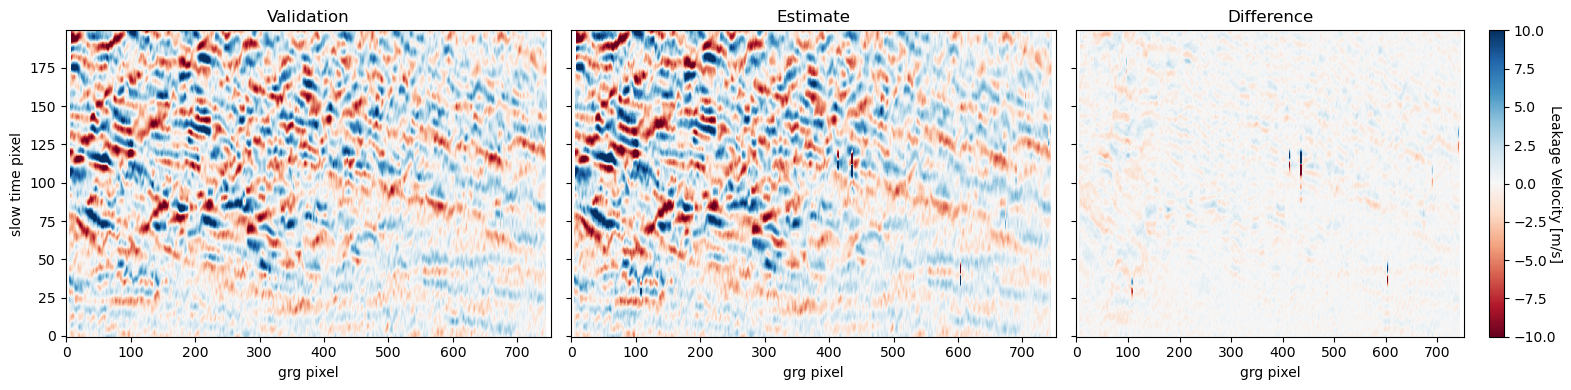

In [11]:
theoretical_length = y_data.isel(placeholder=slice(*test_range_slow_time)).values.reshape(-1).shape
A = np.nan * np.arange(theoretical_length[0])
A[y_test.index.values] = ML2.y_test.values
A = A.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1))

B = np.nan * np.arange(theoretical_length[0])
B[y_test.index.values] = ML2.y_pred
B = B.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1))

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

vmin = -10;
vmax = 10
im0 = axes[0].imshow(A, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
im1 = axes[1].imshow(B.reshape((test_range_slow_time[1] - test_range_slow_time[0], -1)), origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
im2 = axes[2].imshow(A - B, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu')
[ax.set_xlabel('grg pixel') for ax in axes]
axes[0].set_ylabel('slow time pixel')
axes[0].set_title('Validation')
axes[1].set_title('Estimate')
axes[2].set_title('Difference')
cbar = plt.colorbar(im0, ax=axes[2])
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
fig.tight_layout()

## Considering fewer along azimuth points

In [21]:
n = 5
X = xr.concat([data.nrcs_scat.isel(slow_time=slice(i-n, 1+i+n)) for i in range(n, len(data.nrcs_scat['slow_time'])-n)], dim='placeholder').values.reshape(-1, 2*n+1)
y = xr.concat([data.V_leakage_pulse_rg.isel(slow_time=i) for i in range(n, len(data.V_leakage_pulse_rg['slow_time'])-n)], dim='placeholder').values.reshape(-1)

ML2 = AutomatedRegression(
    X=X,
    y=y,
    n_trial=50,
    models_to_optimize=['bayesianridge', 'lightgbm'],
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/n_5_V/',
)

# hideous warning catcher
with warnings.catch_warnings(record=True) as caught_warnings:
    output_buffer = io.StringIO()
    sys.stdout = output_buffer

    result = ML2.apply()
    
sys.stdout = sys.__stdout__

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))
[I 2023-11-16 15:30:54,574] A new study created in RDB with name: regression_bayesianridge
[I 2023-11-16 15:30:56,412] Trial 0 finished with value: -0.7390508198044177 and parameters: {'scaler': 'minmax', 'n_iter': 71, 'tol': 15.59945204206032, 'alpha_1': 3.809220577048033e-08, 'alpha_2': 4.589458612326476, 'lambda_1': 0.010260065124896783, 'lambda_2': 0.12042752972516813, 'transformers': 'quantile_trans', 'n_quantiles': 3400}. Best is trial 0 with value: -0.7390508198044177.
[I 2023-11-16 15:31:06,581] Trial 1 finished with value: -0.7390811010686231 and parameters: {'scaler': 'robust', 'n_iter': 215, 'tol': 43.19450186989213, 'alpha_1': 8.171304639059403e-06, 'alpha_2': 0.013137990612765096, 'lambda_1': 2.4827821051950883e-07, 'lambda_2': 8.345387083873532e-06,

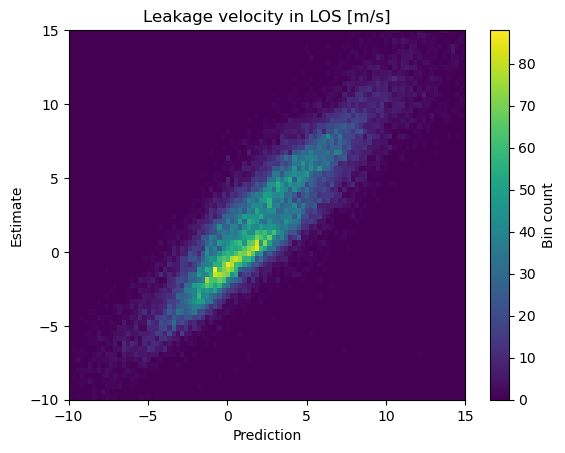

{'bayesianridge_best': [[1.6965574948155606, 0.018917617365346813],
  [0.6075947122337529, 0.006330493964546258]],
 'lightgbm_best': [[1.4092781002490085, 0.016931855477202856],
  [0.7976514026502601, 0.0036824128869723744]],
 'stacked': [[1.3462457072461025, 0.015041901455711354],
  [0.8154682013583644, 0.005548763925790694]]}

In [22]:
plt.hist2d(ML2.y_pred, np.ravel(ML2.y_test.values), bins=(200,200)) #, gridsize=10, cmap='Blues', edgecolors='gray', mincnt=1)
plt.xlim([-10, 15]); plt.ylim([-10, 15])
plt.colorbar(label='Bin count')
plt.title('Leakage velocity in LOS [m/s]')
plt.xlabel('Prediction')
plt.ylabel('Estimate')
plt.show()

ML2.summary